In [2]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import string
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import umap.umap_ as umap

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, OPTICS
from sklearn.mixture import GaussianMixture

from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, f1_score, silhouette_score
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [3]:
# For handling warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\utgoy\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\utgoy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\utgoy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\utgoy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Download the data

In [6]:
train_data = pd.read_csv('./data/train.csv')#.dropna()
val_data = pd.read_csv('./data/val.csv')#.dropna()
test_data = pd.read_csv('./data/test.csv')#.dropna()

In [7]:
# get all train data (labelled and unlabelled)
X_train    = train_data['Phrase']
y_train    = train_data['Sentiment']

# get only labelled train data
mask = (y_train != -100)
train_data_clean    = train_data[mask]
X_train_clean    = X_train[mask]
y_train_clean    = y_train[mask]

# get val data
X_val    = val_data['Phrase']
y_val    = val_data['Sentiment']

# get test data
X_test     = test_data['Phrase']

print(f"Train Data Shape: {X_train.shape}")
print(f"Cleaned Train Data Shape: {train_data_clean['Phrase'].shape}")
print(f"Validation Data Shape: {X_val.shape}")
print(f"Test Data Shape: {X_test.shape}")

print(" ")
print(f"Number of labels = 0 in train dataset as percentage: {((y_train == 0).sum() / (X_train.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 1 in train dataset as percentage: {((y_train == 1).sum() / (X_train.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in train dataset as percentage: {((y_train == 2).sum() / (X_train.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 3 in train dataset as percentage: {((y_train == 3).sum() / (X_train.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 4 in train dataset as percentage: {((y_train == 4).sum() / (X_train.shape[0])) * 100:0.2f}%")
print(f"Number of labels = -100 in train dataset as percentage: {((y_train == -100).sum() / (X_train.shape[0])) * 100:0.2f}%")

print(" ")
print(f"Number of labels = 0 in val dataset as percentage: {((y_val == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 1 in val dataset as percentage: {((y_val == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in val dataset as percentage: {((y_val == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 3 in val dataset as percentage: {((y_val == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 4 in val dataset as percentage: {((y_val == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = -100 in val dataset as percentage: {((y_val == -100).sum() / (X_val.shape[0])) * 100:0.2f}%")

Train Data Shape: (59706,)
Cleaned Train Data Shape: (24758,)
Validation Data Shape: (23256,)
Test Data Shape: (23257,)
 
Number of labels = 0 in train dataset as percentage: 8.33%
Number of labels = 1 in train dataset as percentage: 8.95%
Number of labels = 2 in train dataset as percentage: 5.33%
Number of labels = 3 in train dataset as percentage: 9.60%
Number of labels = 4 in train dataset as percentage: 9.26%
Number of labels = -100 in train dataset as percentage: 58.53%
 
Number of labels = 0 in val dataset as percentage: 19.63%
Number of labels = 1 in val dataset as percentage: 20.27%
Number of labels = 2 in val dataset as percentage: 20.42%
Number of labels = 3 in val dataset as percentage: 19.81%
Number of labels = 4 in val dataset as percentage: 19.88%
Number of labels = -100 in val dataset as percentage: 0.00%


# Vectorization

## Define Preprocessing Helper Functions

In [10]:
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', str(text), flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    #added substitutions

    #***********added substitutions***********
    # remove all the special characters
    texter = re.sub(r'\W', ' ', texter)
    # remove all single characters
    texter = re.sub(r'\s+[a-zA-Z]\s+', ' ', texter)
    # Remove single characters from the start
    texter = re.sub(r'\^[a-zA-Z]\s+', ' ', texter)
    # Remove numbers
    texter = re.sub(r'\d+', ' ', texter)
    # Converting to Lowercase
    texter = texter.lower()
    # Remove punctuation
    texter = re.sub(r'[^\w\s]', ' ', texter)
    # Remove parentheses
    texter = re.sub(r'\([^)]*\)', ' ', texter)
    # Remove single quotes
    texter = re.sub(r'\'', ' ', texter)
    # Substituting multiple spaces with single space
    texter = re.sub(r'\s+', ' ', texter, flags=re.I)

    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

def clean_dataset(dataset):
    for row in range(dataset.shape[0]):
        dataset[row,0] = clean(dataset[row,0])
    return dataset

def tokenize_lexicon(texts):
    return_texts = []
    for i in range(len(texts)):
        return_texts.append(nltk.word_tokenize(texts[i]))
        return_texts[i] = nltk.pos_tag(return_texts[i])
    return return_texts

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wn.ADJ
    elif pos_tag.startswith('V'):
        return wn.VERB
    elif pos_tag.startswith('N'):
        return wn.NOUN
    elif pos_tag.startswith('R'):
        return wn.ADV
    else:
        return wn.NOUN

def lemmatize_texts(texts):
    return_texts = []
    lemmer = nltk.stem.WordNetLemmatizer()
    for i in range(len(texts)):
        return_texts.append([])
        for j in range(len(texts[i])):
                return_texts[i].append(lemmer.lemmatize(texts[i][j][0], pos=get_wordnet_pos(texts[i][j][1])))
    return return_texts

def stem_texts(texts):
    return_texts = []
    ps = PorterStemmer()
    for i in range(len(texts)):
        return_texts.append([])
        for j in range(len(texts[i])):
                return_texts[i].append(ps.stem(texts[i][j][0]))
    return return_texts


def backtostring(texts):
    return_texts = []
    for i in range(len(texts)):
        return_texts.append(" ".join(texts[i]))
    return return_texts

In [11]:
def pre_process(data):
    preproc_data = data.copy()
    preproc_data = preproc_data.str.lower()
    punctuation = string.punctuation
    mapping = str.maketrans("", "", punctuation)
    preproc_data = preproc_data.str.translate(mapping)
    stop_words = set(stopwords.words('english'))
    preproc_data = preproc_data.apply(lambda text: ' '.join([word for word in str(text).split() if word.lower() not in stop_words]))
    # nltk.download('wordnet')
    # lemmatizer = WordNetLemmatizer()
    # preproc_data = preproc_data.apply(lambda text: ' '.join([lemmatizer.lemmatize(word) for word in text.split()]))

    stemmer = PorterStemmer()
    preproc_data = preproc_data.apply(lambda text: ' '.join([stemmer.stem(word) for word in text.split()]))
    
    preproc_data = preproc_data.apply(lambda text: re.sub(r'@\w+', '', re.sub(r'http\S+|www\S+', '', text)))
    return preproc_data

# get the preprocessed data
X_train_preproc   = pre_process(X_train)
X_train_clean_preproc   = pre_process(X_train_clean)
X_val_preproc = pre_process(X_val)
X_test_preproc = pre_process(X_test)

## TF-IDF

In [13]:
porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [66]:
tfidf = TfidfVectorizer(strip_accents='unicode', lowercase=True, tokenizer=tokenizer_porter, stop_words='english')
X_train_preproc_tfidf = tfidf.fit_transform(X_train_preproc)
print(f"\nTF-IDF feature matrix shape: {X_train_preproc_tfidf.shape}")


TF-IDF feature matrix shape: (59706, 10456)


In [67]:
X_val_preproc_tfidf = tfidf.transform(X_val_preproc)
print(f"\nTF-IDF feature matrix shape: {X_val_preproc_tfidf.shape}")


TF-IDF feature matrix shape: (23256, 10456)


# Dimensionality Reduction

In [16]:
import matplotlib.pyplot as plt

def plot_clusters(X, labels, model_name):
    """
    Plots the clusters based on the first two PCA components.

    Parameters:
    - X_pca (numpy.ndarray): PCA-transformed data.
    - labels (array-like): Cluster labels for each data point.
    - model_name (str): Name of the clustering model for the plot title.
    """
    plt.figure(figsize=(8,6))
    unique_clusters = np.unique(labels)
    # Handle noise label for DBSCAN (-1)
    for cluster in unique_clusters:
        if cluster == -1:
            # Assign a distinct color for noise
            color = 'k'
            label = 'Noise'
        else:
            color = plt.cm.tab10(cluster % 10)  # Cycle through colors if more than 10 clusters
            label = f'Cluster {cluster}'
        cluster_data = X[labels == cluster]
        plt.scatter(cluster_data[:,0], cluster_data[:,1], label=label, alpha=0.6, edgecolors='w', linewidth=0.5, s=50, color=color)
    plt.title(f'{model_name} Clustering')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

In [80]:
def assign_labels_with_clustering(df, X, clustering_model, model_name, num_classes=5, plotting=False):
    """
    Assign labels to missing data based on clustering.

    Parameters:
    - df: pandas DataFrame with 'Sentiment' column
    - X: Feature matrix after PCA
    - clustering_model: sklearn clustering model
    - model_name: String name of the clustering model
    - num_classes: Number of sentiment classes

    Returns:
    - df_combined: DataFrame with assigned labels
    """
    print(f"\n--- {model_name} Clustering ---")
    # Fit the clustering model
    clustering_model.fit(X)
    
    # Obtain cluster labels
    if hasattr(clustering_model, 'labels_'):
        clusters = clustering_model.labels_
    else:
        clusters = clustering_model.predict(X)
    
    df['Cluster'] = clusters
   
    # Debug: Show cluster distribution
    print(f"Number of clusters formed: {len(np.unique(clusters))}")
    # print(f"Cluster distribution:\n{pd.Series(clusters).value_counts()}")
    
    # Map each cluster to the most frequent sentiment label within that cluster
    cluster_label_map = {}
    for cluster in np.unique(clusters):
        # Select rows in the current cluster with known labels
        mask = (df['Cluster'] == cluster) & (df['Sentiment'].notnull())
        if mask.sum() == 0:
            # If no labeled data in cluster, assign the most common overall label
            most_common_label = df['Sentiment'].mode()[0]
            cluster_label_map[cluster] = most_common_label
            print(f"Cluster {cluster}: No labeled data. Assigning most common label {most_common_label}.")
        else:
            # Assign the most common label within the cluster           
            most_common_label = df.loc[mask, 'Sentiment'].mode()[0]
            cluster_label_map[cluster] = most_common_label
            print(f"Cluster {cluster}: Assigning label {most_common_label} based on majority voting.")
    
    # Assign labels to missing data
    def assign_label(row):
        if pd.isnull(row['Sentiment']):
            return cluster_label_map[row['Cluster']]
        else:
            return row['Sentiment']
    
    df['Sentiment_Assigned'] = df.apply(assign_label, axis=1)
    
    # Display the mapping
    # print(f"\nCluster to Label Mapping for {model_name}:")
    # for cluster, label in cluster_label_map.items():
    #     print(f"Cluster {cluster}: Label {label}")
    
    # Debug: Check the number of assigned labels
    print("\nLabel Distribution After Assignment:")
    print(df['Sentiment_Assigned'].value_counts())

    if plotting:
        plot_clusters(X, clustering_model.fit_predict(X), model_name)
    
    # Drop the 'Cluster' column as it's no longer needed
    # df = df.drop('Cluster', axis=1)
    return df

In [55]:
def perform_classification(X_train, y_train, X_val, y_val, method_name):
    """
    Train and evaluate classification models using training and validation sets, then evaluate on test set.
    
    Parameters:
    - df_train: Training DataFrame with 'Phrase' and 'Sentiment_Assigned'
    - df_val: Validation DataFrame with 'Phrase' and 'Sentiment_Assigned'
    - df_test: Test DataFrame with 'Phrase' and 'Sentiment' (assuming test set has no missing labels)
    - method_name: String indicating the clustering method used for label assignment
    
    Returns:
    - None
    """
    print(f"\n=== Classification Results using {method_name} Assigned Labels ===")
    
    # Combine training and validation data for training classifiers
    # X_train = X
    # y_train = df_train['Sentiment_Assigned']
    
    # X_val = tfidf.transform(df_val['Phrase'])
    # y_val = df_val['Sentiment']
    
    # ------------------------------
    # 6.1 Logistic Regression
    # ------------------------------
    lr = LogisticRegression(C=5, max_iter=1000, random_state=42)
    lr.fit(X_train, y_train)
    
    # Validate on validation set
    y_val_pred_lr = lr.predict(X_val)
    val_accuracy_lr = lr.score(X_val, y_val)
    print("\n--- Logistic Regression ---")
    print(f"Validation Accuracy: {val_accuracy_lr:.4f}")
    print(f"Validation F1 Score: {f1_score(y_val, y_val_pred_lr, average='weighted'):.4f}")
    print("Validation Classification Report:")
    print(classification_report(y_val, y_val_pred_lr))
    
    # ------------------------------
    # 6.2 Random Forest Classifier
    # ------------------------------
    rf = RandomForestClassifier(n_jobs=-1, random_state=42)
    rf.fit(X_train, y_train)
    
    # Validate on validation set
    y_val_pred_rf = rf.predict(X_val)
    val_accuracy_rf = rf.score(X_val, y_val)
    print("\n--- Random Forest ---")
    print(f"Validation Accuracy: {val_accuracy_rf:.4f}")
    print(f"Validation F1 Score: {f1_score(y_val, y_val_pred_rf, average='weighted'):.4f}")
    print("Validation Classification Report:")
    print(classification_report(y_val, y_val_pred_rf))
    
    # ------------------------------
    # 6.3 LightGBM Classifier
    # ------------------------------

    
    lgbm = LGBMClassifier(n_jobs=-1, verbose = -1, verbose_eval=False)
    lgbm.fit(X_train, y_train)
    
    y_val_pred_lgb_labels = lgbm.predict(X_val)
    val_accuracy_lgb = lgbm.score(X_val, y_val)
    print("\n--- LightGBM ---")
    print(f"Validation Accuracy: {val_accuracy_lgb:.4f}")
    print(f"Validation F1 Score: {f1_score(y_val, y_val_pred_lgb_labels, average='weighted'):.4f}")

    print("Validation Classification Report:")
    print(classification_report(y_val, y_val_pred_lgb_labels))
    
    # ------------------------------
    # 6.4 XGBoost Classifier
    # ------------------------------
    
    xgbm = XGBClassifier(n_jobs=-1)
    xgbm.fit(X_train, y_train)
    
    y_val_pred_xgb_labels = xgbm.predict(X_val)
    val_accuracy_xgb = xgbm.score(X_val, y_val)
    print("\n--- XGBoost ---")
    print(f"Validation Accuracy: {val_accuracy_xgb:.4f}")
    print(f"Validation F1 Score: {f1_score(y_val, y_val_pred_xgb_labels, average='weighted'):.4f}")
    print("Validation Classification Report:")
    print(classification_report(y_val, y_val_pred_xgb_labels))

In [19]:
model_params = {
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10,100],
            'max_depth': [1,2,3,4,5,6],
            'min_samples_leaf': [100,200,300,500,1000]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(max_iter=1000, multi_class='auto'),
        'params': {
            'C': [1,5,10],
            # 'solver':['newton-cg', 'liblinear', 'saga']
        }
    },
        'XGBoost': {
        'model': XGBClassifier(n_jobs=-1),
        "params": {
            'n_estimators': [1,10,100, 500],
            'max_depth': [3,4,5,6, 10],
      
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(n_jobs=-1, verbose = -1,  verbose_eval=False),
        "params": {
            'n_estimators': [1,5,10,100],
            'max_depth': [1,2,3,4,5,6],
            'num_leaves': [100,200,300,500,1000]
        }
    },
}

def perform_classification_tunning(df_train, df_val, method_name):
    """
    Train and evaluate classification models using training and validation sets, then evaluate on test set.
    
    Parameters:
    - df_train: Training DataFrame with 'Phrase' and 'Sentiment_Assigned'
    - df_val: Validation DataFrame with 'Phrase' and 'Sentiment_Assigned'
    - df_test: Test DataFrame with 'Phrase' and 'Sentiment' (assuming test set has no missing labels)
    - method_name: String indicating the clustering method used for label assignment
    
    Returns:
    - None
    """
    print(f"\n=== Classification Results using {method_name} Assigned Labels ===")
    
    # Combine training and validation data for training classifiers
    X_train = tfidf.transform(df_train['Phrase'])
    y_train = df_train['Sentiment_Assigned']
    
    X_val = tfidf.transform(df_val['Phrase'])
    y_val = df_val['Sentiment']
    
    # Encode labels
    le = LabelEncoder()
    le.fit(pd.concat([y_train, y_val]))
    
    y_train_encoded = le.transform(y_train)
    y_val_encoded = le.transform(y_val)
    
    cv = StratifiedKFold(n_splits=3)
    scores = []

    for model_name, mp in model_params.items():
        acc = []
        f1  = []
        
        print(model_name)
        clf =  GridSearchCV(mp['model'], mp['params'], cv=cv,  return_train_score=False)
        clf.fit(X_train, y_train)
        y_val_pred = clf.predict(X_val)
        
        acc.append(accuracy_score(y_val_encoded, y_val_pred))
        f1.append(f1_score(y_val_encoded, y_val_pred, average='weighted'))
        
        scores.append({
            'model': model_name,
            'accuracy': acc,
            'f1_score': f1,
            'accuracy_mean':np.mean(acc),
            'f1_score_mean': np.mean(f1),
            'best_params': clf.best_params_
        })
        
    df = pd.DataFrame(scores,columns=['model','accuracy','f1_score', 'accuracy_mean','f1_score_mean','best_params']).round(4).sort_values('accuracy_mean')
    df.to_csv(f'results_{method_name}.csv', index=False)


    display(df)

## PCA

In [21]:
pca = PCA(n_components=50, random_state=42)  

X_pca = pca.fit_transform(X_train_preproc_tfidf.toarray())
print(f"PCA-reduced feature matrix shape: {X_pca.shape}")

PCA-reduced feature matrix shape: (59706, 50)


In [22]:
model_name = 'PCA'

### Visualization PC 1 vs PC 2

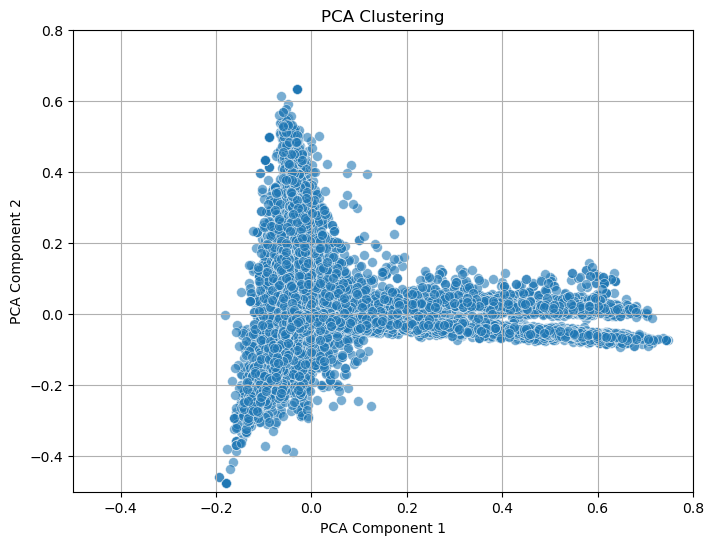

In [24]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.6, edgecolors='w', linewidth=0.5, s=50)
plt.title(f'{model_name} Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
# plt.legend()

plt.xlim(-.5, .8)
plt.ylim(-.5, .8)

plt.grid(True)
plt.show()

### Visualization PC 2 vs PC 3

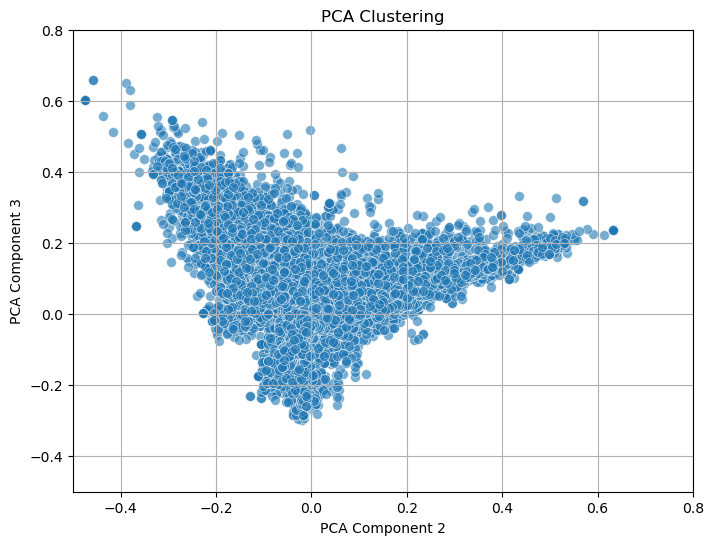

In [26]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,1], X_pca[:,2], alpha=0.6, edgecolors='w', linewidth=0.5, s=50)
plt.title(f'{model_name} Clustering')
plt.xlabel('PCA Component 2')
plt.ylabel('PCA Component 3')
# plt.legend()

plt.xlim(-.5, .8)
plt.ylim(-.5, .8)

plt.grid(True)
plt.show()

### Visualization PC 3 vs PC 4

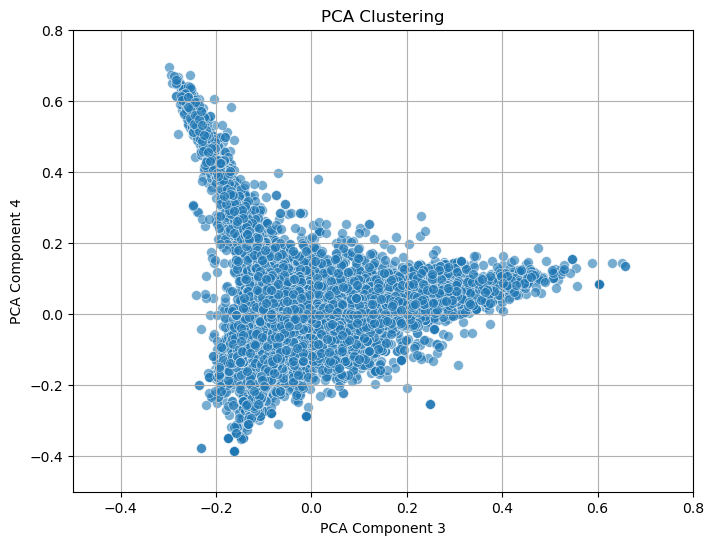

In [28]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,2], X_pca[:,3], alpha=0.6, edgecolors='w', linewidth=0.5, s=50)
plt.title(f'{model_name} Clustering')
plt.xlabel('PCA Component 3')
plt.ylabel('PCA Component 4')

plt.xlim(-.5, .8)
plt.ylim(-.5, .8)

# plt.legend()
plt.grid(True)
plt.show()

## UMAP

In [30]:
umap_reducer = umap.UMAP(n_components=50, random_state=42, )  # Adjust n_components as needed

# Fit and transform TF-IDF features
X_umap = umap_reducer.fit_transform(X_train_preproc_tfidf.toarray())
print(f"UMAP-reduced feature matrix shape: {X_umap.shape}")

UMAP-reduced feature matrix shape: (59706, 50)


In [187]:
model_name = 'UMAP'

### Visualization PC 1 vs PC 2

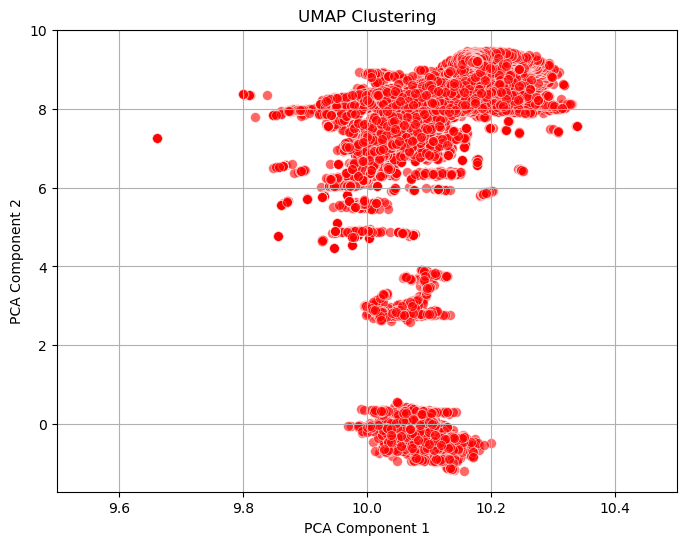

In [190]:
plt.figure(figsize=(8,6))
plt.scatter(X_umap[:,0], X_umap[:,1], alpha=0.6, edgecolors='w', linewidth=0.5, s=50, color='red')
plt.title(f'{model_name} Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
# plt.legend()

plt.xlim(9.5, 10.5)
# plt.ylim(4, 5)

plt.grid(True)
plt.show()

### Visualization PC 2 vs PC 3

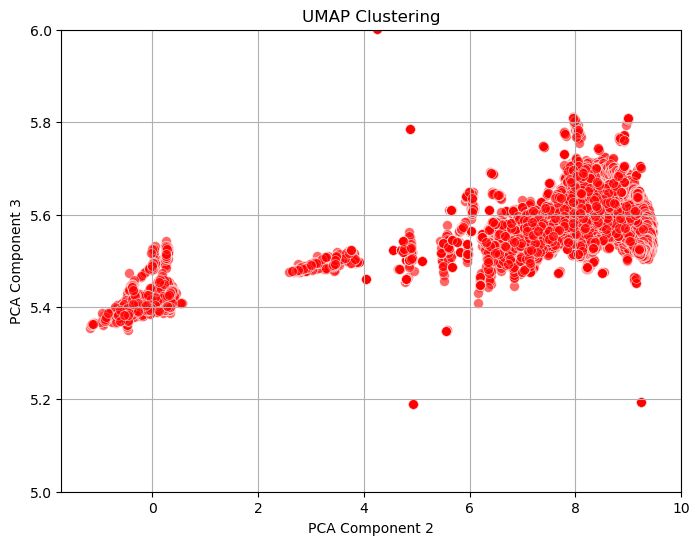

In [198]:
plt.figure(figsize=(8,6))
plt.scatter(X_umap[:,1], X_umap[:,2], alpha=0.6, edgecolors='w', linewidth=0.5, s=50, color='red')
plt.title(f'{model_name} Clustering')
plt.xlabel('PCA Component 2')
plt.ylabel('PCA Component 3')
# plt.legend()

# plt.xlim(4, 5)
plt.ylim(5, 6)

plt.grid(True)
plt.show()

### Visualization PC 3 vs PC 4

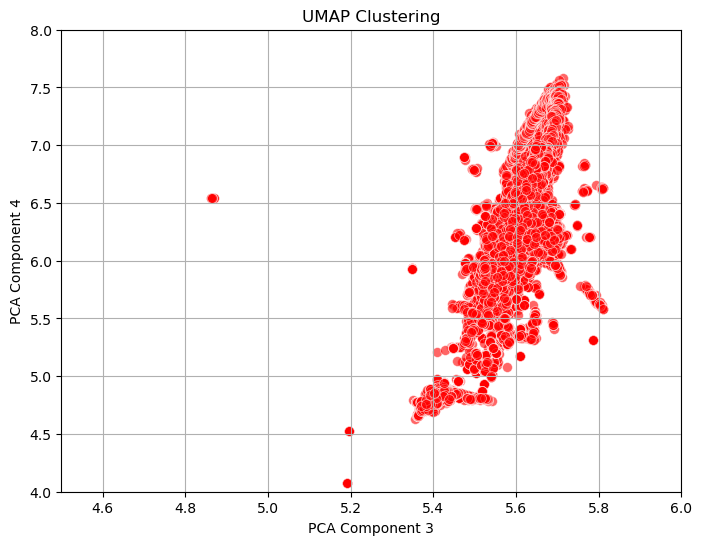

In [208]:
plt.figure(figsize=(8,6))
plt.scatter(X_umap[:,2], X_umap[:,3], alpha=0.6, edgecolors='w', linewidth=0.5, s=50, color='red')
plt.title(f'{model_name} Clustering')
plt.xlabel('PCA Component 3')
plt.ylabel('PCA Component 4')
# plt.legend()

plt.xlim(4.5, 6)
plt.ylim(4, 8)

plt.grid(True)
plt.show()

# Clustering

Given the ellipsoid nature of both dimensionality reduction techqiues, it is best to use GMM since it is able to perform better.  

In [40]:
k_values = [5, 50, 100, 250, 500, 750, 1000]  # Start from 2, as silhouette score needs at least two clusters

## Optimal GMM Clusters

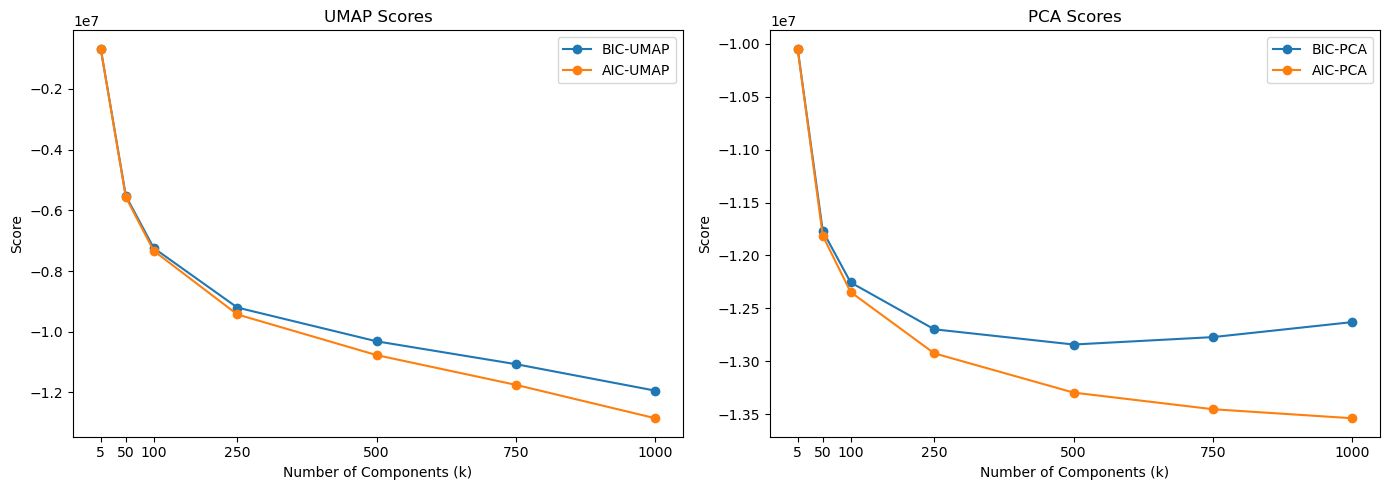

In [42]:
# sample_size = int(59701/5)

# bic_scores_pca = []
# aic_scores_pca = []

# bic_scores_umap = []
# aic_scores_umap = []

# silhouette_scores_gmm = []

# for k in tqdm(k_values, desc="Finding K"):

#     sample_indices = np.random.choice(X_pca.shape[0], size=sample_size, replace=False)
    
#     # Fit a Gaussian Mixture Model (GMM) with k components
#     gmm = GaussianMixture(n_components=k, covariance_type='diag', max_iter=100, reg_covar=1e-4, init_params='kmeans', random_state=42)
#     gmm_labels = gmm.fit_predict(X_pca[sample_indices])

#     # Calculate BIC and AIC
#     bic_scores_pca.append(gmm.bic(X_pca))
#     aic_scores_pca.append(gmm.aic(X_pca))

#     gmm = GaussianMixture(n_components=k, covariance_type='diag', max_iter=100, reg_covar=1e-4, init_params='kmeans', random_state=42)
#     gmm_labels = gmm.fit_predict(X_umap[sample_indices])
#     # Calculate BIC and AIC
#     bic_scores_umap.append(gmm.bic(X_umap))
#     aic_scores_umap.append(gmm.aic(X_umap))

    # print(bic_scores_umap)
    # print(aic_scores_umap)

    # Calculate Silhouette score if k > 1 (Silhouette requires at least 2 clusters)
    # score = silhouette_score(X_pca, gmm_labels)
    # silhouette_scores_gmm.append(score)

bic_scores_pca = [-10046903.765079908, -11768516.826057164, -12254994.691571359, -12697607.571135331, -12841542.659642098, -12771479.471291933, -12629629.958835967]
aic_scores_pca = [-10051438.305520937, -11813943.204403894, -12345856.445368867, -12924775.451285176, -13295887.417045837, -13453001.105949566, -13538328.470747493]

bic_scores_umap = [-679675.1635472373, -5523632.20674975, -7242640.424716241, -9202283.198420955, -10315246.580855194, -11068146.122167017, -11940543.615146823]
aic_scores_umap = [-684209.7039882655, -5569058.585096479, -7333502.178513749, -9429451.0785708, -10769591.338258933, -11749667.75682465, -12849242.12705835]

# Plot the metrics for GMM
plt.figure(figsize=(14, 5))

# Plot BIC and AIC scores
plt.subplot(1, 2, 1)
plt.plot(k_values, bic_scores_umap, marker='o', label='BIC-UMAP')
plt.plot(k_values, aic_scores_umap, marker='o',  label='AIC-UMAP')
plt.xticks(k_values)
plt.xlabel('Number of Components (k)')
plt.ylabel('Score')
plt.title('UMAP Scores')
plt.legend()

# Plot the Silhouette Scores for GMM
plt.subplot(1, 2, 2)
plt.plot(k_values, bic_scores_pca, marker='o', label='BIC-PCA')
plt.plot(k_values, aic_scores_pca, marker='o',  label='AIC-PCA')
plt.xticks(k_values)
plt.xlabel('Number of Components (k)')
plt.ylabel('Score')
plt.title('PCA Scores')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [43]:
# [-10046903.765079908, -11768516.826057164, -12254994.691571359, -12697607.571135331, -12841542.659642098, -12771479.471291933, -12629629.958835967]
# [-10051438.305520937, -11813943.204403894, -12345856.445368867, -12924775.451285176, -13295887.417045837, -13453001.105949566, -13538328.470747493]
# [-679675.1635472373, -5523632.20674975, -7242640.424716241, -9202283.198420955, -10315246.580855194, -11068146.122167017, -11940543.615146823]
# [-684209.7039882655, -5569058.585096479, -7333502.178513749, -9429451.0785708, -10769591.338258933, -11749667.75682465, -12849242.12705835]

# Regression

## PCA-GMM

In [152]:
gmm = GaussianMixture(n_components=100, random_state=42)

df_train = train_data.copy()
df_train['Sentiment'] = np.where(df_train['Sentiment']==-100, np.nan, df_train['Sentiment'])

df_gmm = assign_labels_with_clustering(df_train, X_pca, gmm, 'Gaussian Mixture Model')


--- Gaussian Mixture Model Clustering ---
Number of clusters formed: 100
Cluster 0: Assigning label 4.0 based on majority voting.
Cluster 1: Assigning label 0.0 based on majority voting.
Cluster 2: Assigning label 2.0 based on majority voting.
Cluster 3: Assigning label 2.0 based on majority voting.
Cluster 4: Assigning label 3.0 based on majority voting.
Cluster 5: Assigning label 3.0 based on majority voting.
Cluster 6: Assigning label 3.0 based on majority voting.
Cluster 7: Assigning label 0.0 based on majority voting.
Cluster 8: Assigning label 4.0 based on majority voting.
Cluster 9: Assigning label 1.0 based on majority voting.
Cluster 10: Assigning label 0.0 based on majority voting.
Cluster 11: Assigning label 1.0 based on majority voting.
Cluster 12: Assigning label 4.0 based on majority voting.
Cluster 13: Assigning label 4.0 based on majority voting.
Cluster 14: Assigning label 1.0 based on majority voting.
Cluster 15: Assigning label 4.0 based on majority voting.
Cluster 

### Visualization PC 1 vs PC 2

In [154]:
model_name = 'PCA-GMM'

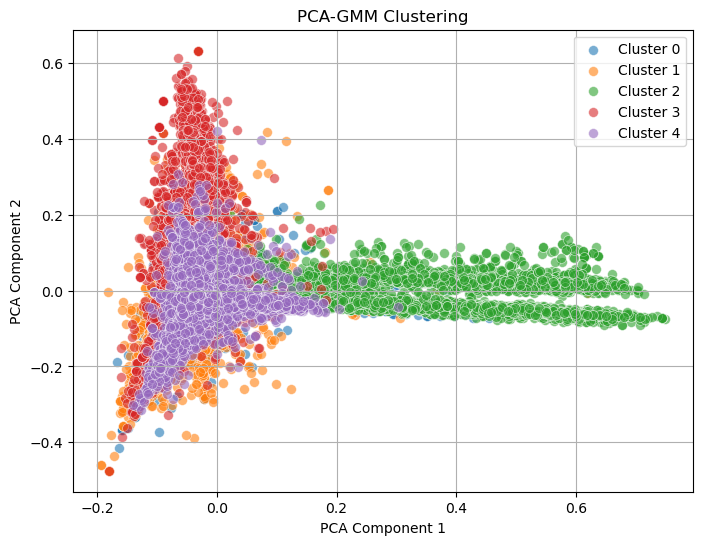

In [155]:
plt.figure(figsize=(8,6))
unique_clusters = np.unique(df_gmm['Sentiment_Assigned'].astype(int))
# Handle noise label for DBSCAN (-1)
for cluster in unique_clusters:
    if cluster == -1:
        # Assign a distinct color for noise
        color = 'k'
        label = 'Noise'
    else:
        color = plt.cm.tab10(cluster)  # Cycle through colors if more than 10 clusters
        label = f'Cluster {cluster}'
    cluster_data = X_pca[df_gmm['Sentiment_Assigned'] == cluster]
    plt.scatter(cluster_data[:,0], cluster_data[:,1], label=label, alpha=0.6, edgecolors='w', linewidth=0.5, s=50, color=color)
plt.title(f'{model_name} Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

### Visualization PC 2 vs PC 3

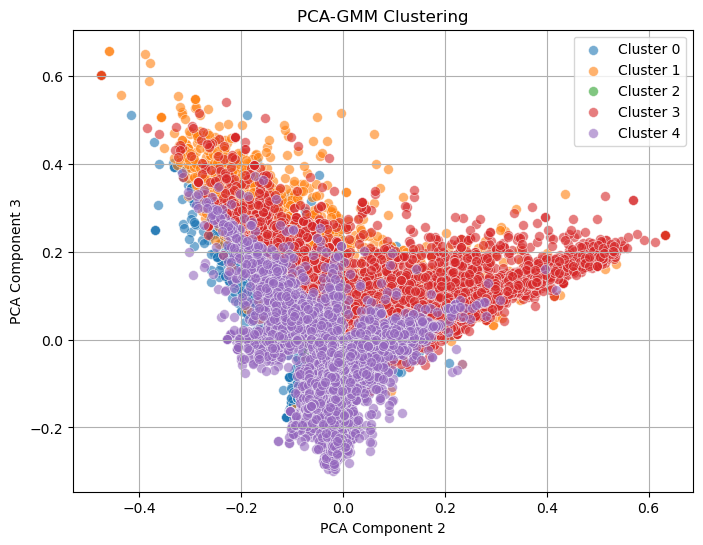

In [157]:
plt.figure(figsize=(8,6))
unique_clusters = np.unique(df_gmm['Sentiment_Assigned'].astype(int))
# Handle noise label for DBSCAN (-1)
for cluster in unique_clusters:
    if cluster == -1:
        # Assign a distinct color for noise
        color = 'k'
        label = 'Noise'
    else:
        color = plt.cm.tab10(cluster)  # Cycle through colors if more than 10 clusters
        label = f'Cluster {cluster}'
    cluster_data = X_pca[df_gmm['Sentiment_Assigned'] == cluster]
    plt.scatter(cluster_data[:,1], cluster_data[:,2], label=label, alpha=0.6, edgecolors='w', linewidth=0.5, s=50, color=color)
plt.title(f'{model_name} Clustering')
plt.xlabel('PCA Component 2')
plt.ylabel('PCA Component 3')
plt.legend()
plt.grid(True)
plt.show()

### Visualization PC 3 vs PC 4

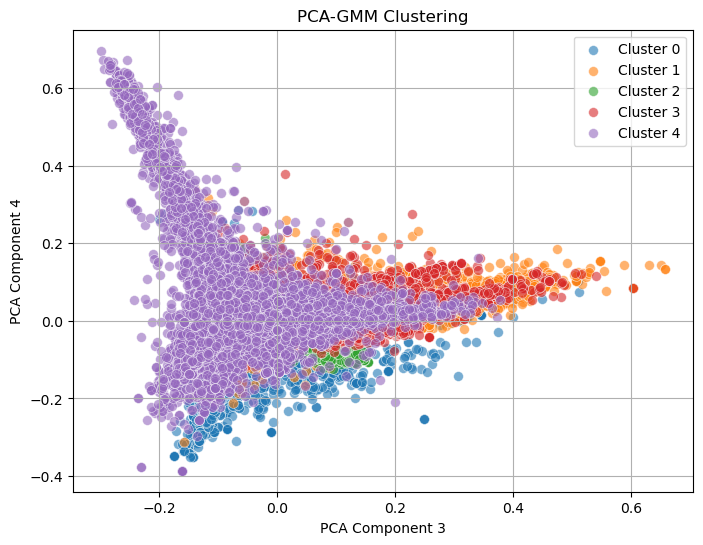

In [159]:
plt.figure(figsize=(8,6))
unique_clusters = np.unique(df_gmm['Sentiment_Assigned'].astype(int))
# Handle noise label for DBSCAN (-1)
for cluster in unique_clusters:
    if cluster == -1:
        # Assign a distinct color for noise
        color = 'k'
        label = 'Noise'
    else:
        color = plt.cm.tab10(cluster)  # Cycle through colors if more than 10 clusters
        label = f'Cluster {cluster}'
    cluster_data = X_pca[df_gmm['Sentiment_Assigned'] == cluster]
    plt.scatter(cluster_data[:,2], cluster_data[:,3], label=label, alpha=0.6, edgecolors='w', linewidth=0.5, s=50, color=color)
plt.title(f'{model_name} Clustering')
plt.xlabel('PCA Component 3')
plt.ylabel('PCA Component 4')
plt.legend()
plt.grid(True)
plt.show()

In [160]:
perform_classification(X_train_preproc_tfidf, df_gmm['Sentiment_Assigned'], X_val_preproc_tfidf, y_val, 'Gaussian Mixture Model')


=== Classification Results using Gaussian Mixture Model Assigned Labels ===

--- Logistic Regression ---
Validation Accuracy: 0.8597
Validation F1 Score: 0.8592
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      4564
           1       0.80      0.74      0.77      4714
           2       0.98      0.97      0.98      4748
           3       0.78      0.80      0.79      4606
           4       0.86      0.91      0.89      4624

    accuracy                           0.86     23256
   macro avg       0.86      0.86      0.86     23256
weighted avg       0.86      0.86      0.86     23256


--- Random Forest ---
Validation Accuracy: 0.8577
Validation F1 Score: 0.8577
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      4564
           1       0.81      0.77      0.79      4714
           2       0.99      0.96      

## UMAP-GMM

In [135]:
gmm = GaussianMixture(n_components=100, random_state=42)

df_train = train_data.copy()
df_train['Sentiment'] = np.where(df_train['Sentiment']==-100, np.nan, df_train['Sentiment'])

df_gmm = assign_labels_with_clustering(df_train, X_umap, gmm, 'Gaussian Mixture Model')


--- Gaussian Mixture Model Clustering ---
Number of clusters formed: 100
Cluster 0: Assigning label 1.0 based on majority voting.
Cluster 1: Assigning label 2.0 based on majority voting.
Cluster 2: Assigning label 2.0 based on majority voting.
Cluster 3: Assigning label 4.0 based on majority voting.
Cluster 4: Assigning label 0.0 based on majority voting.
Cluster 5: Assigning label 4.0 based on majority voting.
Cluster 6: Assigning label 3.0 based on majority voting.
Cluster 7: Assigning label 4.0 based on majority voting.
Cluster 8: Assigning label 0.0 based on majority voting.
Cluster 9: Assigning label 3.0 based on majority voting.
Cluster 10: Assigning label 0.0 based on majority voting.
Cluster 11: Assigning label 0.0 based on majority voting.
Cluster 12: Assigning label 0.0 based on majority voting.
Cluster 13: Assigning label 2.0 based on majority voting.
Cluster 14: Assigning label 4.0 based on majority voting.
Cluster 15: Assigning label 2.0 based on majority voting.
Cluster 

### Visualization PC 1 vs PC 2

In [175]:
model_name = 'UMAP-GMM'

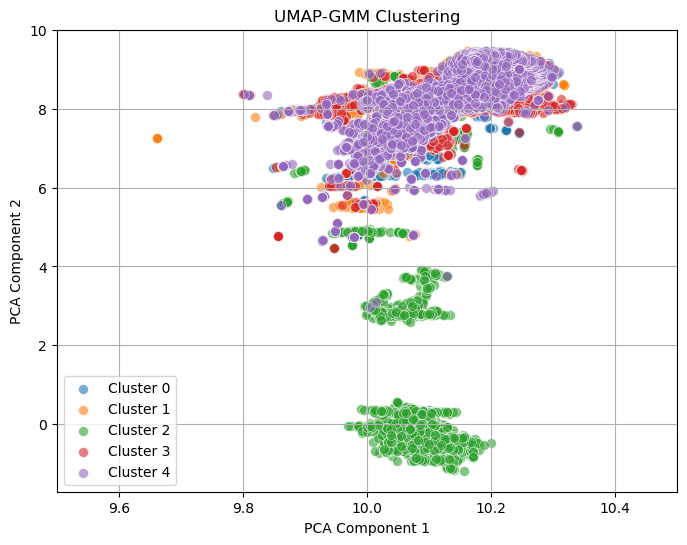

In [183]:
plt.figure(figsize=(8,6))
unique_clusters = np.unique(df_gmm['Sentiment_Assigned'].astype(int))
# Handle noise label for DBSCAN (-1)
for cluster in unique_clusters:
    if cluster == -1:
        # Assign a distinct color for noise
        color = 'k'
        label = 'Noise'
    else:
        color = plt.cm.tab10(cluster)  # Cycle through colors if more than 10 clusters
        label = f'Cluster {cluster}'
    cluster_data = X_umap[df_gmm['Sentiment_Assigned'] == cluster]
    plt.scatter(cluster_data[:,0], cluster_data[:,1], label=label, alpha=0.6, edgecolors='w', linewidth=0.5, s=50, color=color)
plt.title(f'{model_name} Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()

plt.xlim(9.5, 10.5)
# plt.ylim(4, 5)

plt.grid(True)
plt.show()

### Visualization PC 2 vs PC 3

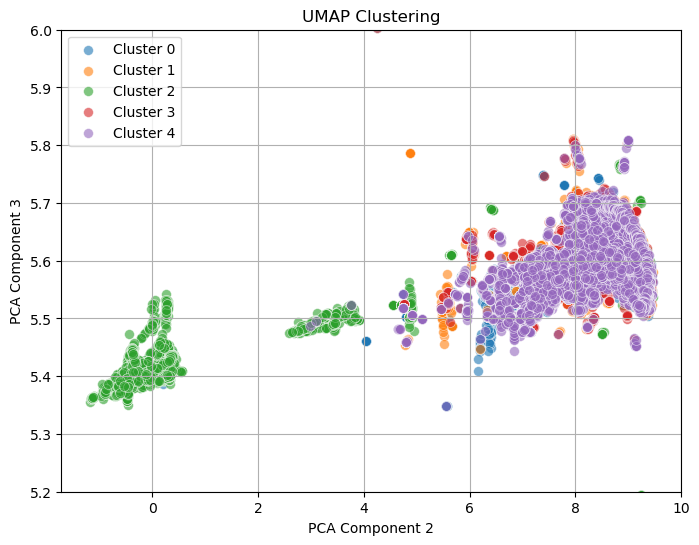

In [202]:
plt.figure(figsize=(8,6))
unique_clusters = np.unique(df_gmm['Sentiment_Assigned'].astype(int))
# Handle noise label for DBSCAN (-1)
for cluster in unique_clusters:
    if cluster == -1:
        # Assign a distinct color for noise
        color = 'k'
        label = 'Noise'
    else:
        color = plt.cm.tab10(cluster)  # Cycle through colors if more than 10 clusters
        label = f'Cluster {cluster}'
    cluster_data = X_umap[df_gmm['Sentiment_Assigned'] == cluster]
    plt.scatter(cluster_data[:,1], cluster_data[:,2], label=label, alpha=0.6, edgecolors='w', linewidth=0.5, s=50, color=color)
plt.title(f'{model_name} Clustering')
plt.xlabel('PCA Component 2')
plt.ylabel('PCA Component 3')
plt.legend()

plt.ylim(5.2, 6)

plt.grid(True)
plt.show()

### Visualization PC 3 vs PC 4

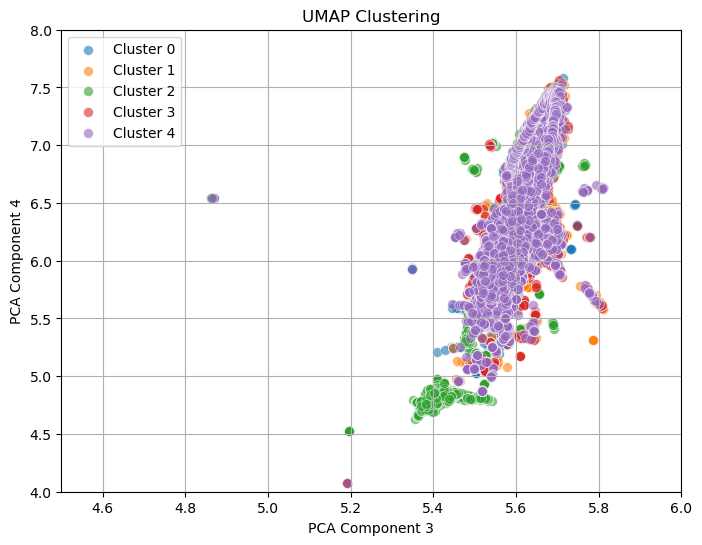

In [210]:
plt.figure(figsize=(8,6))
unique_clusters = np.unique(df_gmm['Sentiment_Assigned'].astype(int))
# Handle noise label for DBSCAN (-1)
for cluster in unique_clusters:
    if cluster == -1:
        # Assign a distinct color for noise
        color = 'k'
        label = 'Noise'
    else:
        color = plt.cm.tab10(cluster)  # Cycle through colors if more than 10 clusters
        label = f'Cluster {cluster}'
    cluster_data = X_umap[df_gmm['Sentiment_Assigned'] == cluster]
    plt.scatter(cluster_data[:,2], cluster_data[:,3], label=label, alpha=0.6, edgecolors='w', linewidth=0.5, s=50, color=color)
plt.title(f'{model_name} Clustering')
plt.xlabel('PCA Component 3')
plt.ylabel('PCA Component 4')
plt.legend()

plt.xlim(4.5, 6)
plt.ylim(4, 8)

plt.grid(True)
plt.show()

In [142]:
perform_classification(X_train_preproc_tfidf, df_gmm['Sentiment_Assigned'], X_val_preproc_tfidf, y_val, 'Gaussian Mixture Model')


=== Classification Results using Gaussian Mixture Model Assigned Labels ===

--- Logistic Regression ---
Validation Accuracy: 0.8304
Validation F1 Score: 0.8290
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.85      0.82      4564
           1       0.81      0.68      0.74      4714
           2       0.94      0.96      0.95      4748
           3       0.76      0.79      0.78      4606
           4       0.85      0.86      0.85      4624

    accuracy                           0.83     23256
   macro avg       0.83      0.83      0.83     23256
weighted avg       0.83      0.83      0.83     23256


--- Random Forest ---
Validation Accuracy: 0.8529
Validation F1 Score: 0.8521
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      4564
           1       0.84      0.73      0.78      4714
           2       0.97      0.97      

# Scratch

In [143]:
gmm = GaussianMixture(n_components=1000, random_state=42)

df_train = train_data.copy()
df_train['Sentiment'] = np.where(df_train['Sentiment']==-100, np.nan, df_train['Sentiment'])

df_gmm = assign_labels_with_clustering(df_train, X_umap, gmm, 'Gaussian Mixture Model')

perform_classification(X_train_preproc_tfidf, df_gmm['Sentiment_Assigned'], X_val_preproc_tfidf, y_val, 'Gaussian Mixture Model')


--- Gaussian Mixture Model Clustering ---
Number of clusters formed: 1000
Cluster 0: Assigning label 1.0 based on majority voting.
Cluster 1: Assigning label 2.0 based on majority voting.
Cluster 2: Assigning label 4.0 based on majority voting.
Cluster 3: Assigning label 0.0 based on majority voting.
Cluster 4: Assigning label 0.0 based on majority voting.
Cluster 5: Assigning label 3.0 based on majority voting.
Cluster 6: Assigning label 4.0 based on majority voting.
Cluster 7: Assigning label 4.0 based on majority voting.
Cluster 8: Assigning label 0.0 based on majority voting.
Cluster 9: Assigning label 4.0 based on majority voting.
Cluster 10: Assigning label 3.0 based on majority voting.
Cluster 11: Assigning label 1.0 based on majority voting.
Cluster 12: Assigning label 1.0 based on majority voting.
Cluster 13: Assigning label 0.0 based on majority voting.
Cluster 14: Assigning label 4.0 based on majority voting.
Cluster 15: Assigning label 2.0 based on majority voting.
Cluster